# COMP5329 - Deep Learning
## Tutorial 2 - Multilayer Neural Network

**Semester 1, 2020**

**Objectives:**

* To understand the multi-layer perceptron.
* To become familiar with backpropagation.


**Instructions:**

* Go to File->Open. Drag and drop "lab2MLP_student.ipynb" file to the home interface and click upload.
* Read the code and complete the exercises.
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.

## Loading the packages

In [1]:
# $ python -m pip install realpython-reader
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
import os
import datetime
import time

 ## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate [-1,1], y coordinate [-1,1] and the class {1,-1}.

In [2]:
# %matplotlib notebook

# fig = pl.figure(figsize=(6,6))
# pl.title("Input Dataset")
# pl.xlim((-2,2))
# pl.ylim((-2,2))

# dataset = []

# def onclick(event):
#     global dataset
#     cx = event.xdata
#     cy = event.ydata
#     co = event.button
#     dataset.append((cx, cy, co-2))

#     pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
#     pl.grid(True)

# cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [3]:
%matplotlib inline

## Show the dataset

In [4]:
# # Un-comment this code block if you are using Google Colab
# class_1 = np.hstack([np.random.normal( 1, 1, size=(25, 2)),  np.ones(shape=(25, 1))])
# class_2 = np.hstack([np.random.normal(-1, 1, size=(25, 2)), -np.ones(shape=(25, 1))])
# dataset = np.vstack([class_1, class_2])
# dataset

In [5]:
# pl.figure(figsize=(6, 6))
# pl.scatter(class_1[:,0], class_1[:,1], label='+1')
# pl.scatter(class_2[:,0], class_2[:,1], label='-1')
# pl.grid()
# pl.legend()
# pl.show()

## Definition of some activation functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

In [6]:
# init 
#class Activation(object):
#     def __tanh(self, x):
#         return np.tanh(x)

#     def __tanh_deriv(self, a):
#         # a = np.tanh(x)   
#         return 1.0 - a**2
#     def __logistic(self, x):
#         return 1.0 / (1.0 + np.exp(-x))

#     def __logistic_deriv(self, a):
#         # a = logistic(x) 
#         return  a * (1 - a )
    
#     def __init__(self,activation='tanh'):
#         if activation == 'logistic':
#             self.f = self.__logistic
#             self.f_deriv = self.__logistic_deriv
#         elif activation == 'tanh':
#             self.f = self.__tanh
#             self.f_deriv = self.__tanh_deriv

class Activation(object):
    ''' Three activation functions are defined here: tanh, sigmoid and leaky relu '''
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )

    def __relu(self,x,alpha=0.05):
        return np.where(x>=0, x, 0)

    def __relu_deriv(self,a,alpha=0.05):
        # a = relu(x)
        return np.where(a > 0, 1, 0.001)

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

### Define HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [7]:
# class HiddenLayer(object):    
#     def __init__(self,n_in, n_out,
#                  activation_last_layer='tanh',activation='tanh', W=None, b=None):

#         self.input=None
#         self.activation=Activation(activation).f
        
#         # activation deriv of last layer
#         self.activation_deriv=None
#         if activation_last_layer:
#             self.activation_deriv=Activation(activation_last_layer).f_deriv

#         self.W = np.random.uniform(
#                 low=-np.sqrt(6. / (n_in + n_out)),
#                 high=np.sqrt(6. / (n_in + n_out)),
#                 size=(n_in, n_out)
#         )
#         if activation == 'logistic':
#             self.W *= 4

#         self.b = np.zeros(n_out,)
        
#         self.grad_W = np.zeros(self.W.shape)
#         self.grad_b = np.zeros(self.b.shape)
        
#     def forward(self, input):
#         '''
#         :type input: numpy.array
#         :param input: a symbolic tensor of shape (n_in,)
#         '''
#         lin_output = np.dot(input, self.W) + self.b
#         self.output = (
#             lin_output if self.activation is None
#             else self.activation(lin_output)
#         )
#         self.input=input
#         return self.output
    
#     def backward(self, delta, output_layer=False):         
#         self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
#         self.grad_b = delta
#         if self.activation_deriv:
#             delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
#         return delta

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):

        self.input=None
        self.activation=Activation(activation).f

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4
          
        if activation == 'relu':
          self.W = np.random.uniform(
              low = -np.sqrt(6./n_in),
              high = np.sqrt(6./n_in),
              size = (n_in, n_out)
          )

        self.b = np.zeros(n_out,)

        # initialize parameters for momentum 
        self.Vp = np.zeros(self.W.shape)
        self.V = np.zeros(self.W.shape)


        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

    def forward(self, input, dropout = 0.2):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''

        ''' randomly generate a random sample from an array with input size for dropout'''
        index = np.random.choice(np.arange(input.size), replace=False, size=int(input.size * dropout))
        input[index] = 0

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output

    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

    '''generate batches avoiding training all data for a single training time'''
    def generate_batches(X, y, batch_size):

        rand = np.random.choice(len(y), len(y), replace=False)
        X_shuffled = X[rand]
        y_shuffled = np.array(y)[rand.astype(int)]
        batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for i in range(0, len(y), batch_size)]
        return batches


    def crossentropy_loss(y, y_hat,epsilon):
        y_hat = np.clip(y_hat, epsilon, 1-epsilon)
        N = y_hat.shape[0]
        # add a super small number 1e-5 avoiding the log0
        loss = -np.sum(y*np.log(y_hat+1e-5))/N
        return loss

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.

In [8]:
class MLP:
    """
    """  
    def __init__(self, layers, activation,learning_rate, momentum, weight_decay, epochs, batch_size, dropout):
#     def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
#         self.layers=[]
#         self.params=[]
        self.layers=[]
        self.params=[]
        self.activation=activation
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
    
#         self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
#     def criterion_MSE(self,y,y_hat):
#         activation_deriv=Activation(self.activation[-1]).f_deriv
#         # MSE
#         error = y-y_hat
#         loss=error**2
#         # calculate the delta of the output layer
#         delta=-error*activation_deriv(y_hat)    
#         # return loss and delta
#         return loss,delta
    def criterion_CrossEntropyLoss(self,y,y_hat,epsilon):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat       
        loss = HiddenLayer.crossentropy_loss(y,y_hat,epsilon)
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta
    
    
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
    
    
     # update weight and bias with momentum 
    def update(self):
        for layer in self.layers:
            V = self.momentum*layer.Vp - self.learning_rate * self.weight_decay*layer.W - self.learning_rate * layer.grad_W
            layer.Vp = layer.V
            layer.V = V
            layer.W += layer.V
            layer.b -= lr * layer.grad_b

    def get_grads(self):
        layer_grad_W=[]
        layer_grad_b=[]
        for j in range(len(self.layers)):
            layer_grad_W.append(self.layers[j].grad_W)
            layer_grad_b.append(self.layers[j].grad_b)
        return layer_grad_W, layer_grad_b
    
    def batch_update(self,dW,db):
        for j in range(len(self.layers)):
            V = self.momentum*self.layers[j].Vp - self.learning_rate * self.weight_decay * self.layers[j].W - self.learning_rate*dW[j]
            self.layers[j].Vp = self.layers[j].V
            self.layers[j].V = V
            self.layers[j].W += self.layers[j].V
            self.layers[j].b -= self.learning_rate * db[j]
    
#     def update(self,lr):
#         for layer in self.layers:
#             layer.W -= lr * layer.grad_W
#             layer.b -= lr * layer.grad_b



#     def fit(self,X,y,learning_rate=0.1, epochs=100):
#         """
#         Online learning.
#         :param X: Input data or features
#         :param y: Input targets
#         :param learning_rate: parameters defining the speed of learning
#         :param epochs: number of times the dataset is presented to the network for learning
#         """ 
#         X=np.array(X)
#         y=np.array(y)
#         to_return = np.zeros(epochs)
        
#         for k in range(epochs):
#             loss=np.zeros(X.shape[0])
#             for it in range(X.shape[0]):
#                 i=np.random.randint(X.shape[0])
                
#                 # forward pass
#                 y_hat = self.forward(X[i])
                
#                 # backward pass
#                 loss[it],delta=self.criterion_MSE(y[i],y_hat)
#                 self.backward(delta)
#                 y
#                 # update
#                 self.update(learning_rate)
#             to_return[k] = np.mean(loss)
#         return to_return

    def fit(self,X,y):
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(self.epochs)

        for k in range(self.epochs):
            # applying mini batch
            batches = HiddenLayer.generate_batches(X,y,self.batch_size)
            loss = np.zeros(len(batches))
            i = 0
            for batch in batches:
                X_batch = np.array(batch[0])
                Y_batch = np.array(batch[1])
                dW = []
                db = []
                loss=np.zeros(X_batch.shape[0])

                for i in range(X_batch.shape[0]):
                    # forward pass
                    y_hat = self.forward(X_batch[i])
                    # backward pass
                    loss[i],delta=self.criterion_CrossEntropyLoss(Y_batch[i],y_hat,epsilon = 1e-3)
                    self.backward(delta)
                    layer_grad_W, layer_grad_b = self.get_grads()
                    dW.append(layer_grad_W)
                    db.append(layer_grad_b)
                loss[i] = np.mean(loss)
                i += 1 
                gradients_W = {}
                gradients_b = {}
                for i in range(len(self.layers)): #could replace with len(self.layers)
                    gradients_W[i] = np.array([j[i] for j in dW]).mean(axis=0)
                    gradients_b[i] = np.array([j[i] for j in db]).mean(axis=0)
                DW=[i for j,i in gradients_W.items()]
                Db=[i for j,i in gradients_b.items()]
                # update weights with batch gradient
                self.batch_update(DW, Db)
            to_return[k] = np.mean(loss)
            print(k)
            print(to_return[k])
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(x[i,:])
        return output

load the data

In [9]:
datapath = '/Users/xuyangwang/OneDrive/USYD/2020_Sem_1/comp5329/assignment/Assignment1/'
with h5py.File(datapath + 'train_128.h5','r') as H: data = np.copy(H['data'])
with h5py.File(datapath + 'train_label.h5','r') as H: label = np.copy(H['label'])
with h5py.File(datapath + 'test_128.h5','r') as H: test_data= np.copy(H['data'])


In [10]:
# split data
def train_val_split(data, label, ratio=0.75, shuffle=False,):
    # ratio为train/validation,默认75%
    # shuffle为是否要打乱顺序，默认否
    # train,train_label为训练数据
    # val, val_label为验证数据
    if shuffle:
        state = np.random.get_state()
        np.random.shuffle(data)
        np.random.set_state(state)
        np.random.shuffle(label)
    train = data[0: int(len(data)*ratio)]
    val = data[int(len(data)*ratio):]
    train_label = label[0: int(len(label)*ratio)]
    val_label = label[int(len(label)*ratio):]
    return train, val, train_label, val_label

t1, v1, l1, l2 = train_val_split(data, label)
print(t1[:, 0])
print(v1[:, 0])
print(l1)
print(l2)

[ -126.50293754  1407.56479437  -725.43035798 ...  -328.80667176
 -1426.96480537 -1229.96692076]
[  262.78658603  -733.28989586  -706.37046352 ...   857.96882043
  -807.27409517 -1815.59879024]
[9 0 0 ... 6 7 8]
[2 9 6 ... 3 0 5]


In [11]:
# parameter setting
layers = [128,50,10,1]
activation = [None,'tanh','tanh','relu']
learning_rate=0.01
momentum=0.9
weight_decay=0.05
epochs=100
batch_size=128
dropout = 0.2

## Learning

In [12]:
nn = MLP(layers, activation,learning_rate, momentum, weight_decay, epochs, batch_size, dropout)
# ### Try different MLP models
# nn = MLP([128,10,10], [None,'logistic','tanh']) #MLP(layers, activation)

# # nn = MLP([2,3,1], [None,'logistic','tanh'])
# # input_data = dataset[:,0:2] # data shape (50,2)
# # output_data = dataset[:,2] # label shape (50,)

# # print(input_data)
# # print(input_data.shape)
# # print(output_data)
# # print(output_data.shape)

In [13]:
tic = time.perf_counter()
crossentropy = nn.fit(t1, l1)
toc = time.perf_counter()

print('loss : %f'%crossentropy[-1])
print(f"Training done in {toc - tic:0.4f} seconds")

# ### Try different learning rate and epochs
# MSE = nn.fit(input_data, output_data, learning_rate=0.01, epochs=10)
# print(MSE)
# # MSE = nn.fit(input_data, output_data, learning_rate=0.01, epochs=500)
# # print('loss :%f'%MSE[-1])

0
10.88302378528441
1
11.760993378843182
2
10.59522540528082
3
9.42882283035922
4
11.07649181232697
5
0.36192425912081166
6
0.003446463225370473
7
0.005217270475217105
8
0.004380015687902913
9
0.004366067810341539
10
0.004492362975657531
11
0.00442205038740294
12
0.004045648760061781
13
0.004311613767807412
14
0.0044505193429734136
15
0.0045899981185871415
16
0.0047153379498235904
17
0.0050504691449283585
18
0.0038641352849480234
19
0.00471533794982359
20
0.003976864706334462
21
0.004156849646920945
22
0.004575285973762133
23
0.004533251274262105
24
0.0041713707249300454
25
0.005342037106005825
26
0.004687251127884934
27
0.00443657146541204
28
0.004464085086902968
29
0.004673112183507652
30
0.004018326205386762
31
0.004492554042473441
32
0.003961770427877633
33
0.003837385930720733
34
0.0044774597640166135
35
0.004450328276157505
36
0.004296519489350583
37
0.004352119932780166
38
0.003933683605938979
39
0.00435345740049153
40
0.004686868994253116
41
0.0041434749698073
42
0.004729859027

record
1. loss:20.563838 (128,10,1)+500 epochs


2.loss : 0.004535 <full data set

#### Plot loss in epochs

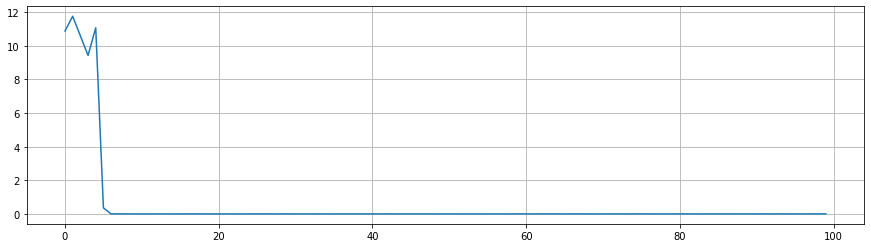

In [14]:
pl.figure(figsize=(15,4))
pl.plot(crossentropy)
pl.grid()

## Testing

In [15]:
output = nn.predict(5)
print(np.array(output))
print(output.shape)

IndexError: tuple index out of range

In [ ]:
pl.figure(figsize=(8,6))
pl.scatter(output_data, output, s=100)
pl.xlabel('Targets')
pl.ylabel('MLP output')
pl.grid()

In [ ]:
# create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-2, 2, .02),np.arange(-2, 2, .02))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output_data], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('Targets')
pl.subplot(1,2,2)
pl.pcolormesh(xx, yy, Z>0, cmap='cool')
pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[d>0] for d in output], s=100)
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.grid()
pl.title('MLP output')